# Projeto: Tentilhões de Darwin

Nesse projeto utilizarei dados de um lugar que contribuiu muito para a Teoria da Evolução de Charles Darwin! No qual foram coletados no arquipélago de Galapagos, particularmente no estudos de pequenos pássaros que habitam esse lugar, chamados tentilhões!   

![](Charles_Darwin_1880.jpg)

Ilhas são ideais para estudos relacionados a evolução pelo fato de serem isoladas, logo as espécies que habitam esses lugares estão livres de efeitos das interações complicadas que podem ocorrer com outras espécies, incluindo os humanos.

Desde de 1973, Peter and Rosemary Grant da Universidade de Princetown tem passado muitos meses do ano na minúscula ilha vulcânica Daphne Major nas Ilhas Galapagos.

![](volcanic_island.jpg)

Essa ilha possui dois grupos de espécies de tentilhões dominantes, o _Geospiza fortis_ (imagem superior) e _Geospiza scandens_ (imagem inferior). 

![](birds.jpg)

Os Grant tem monitorado a população desses pássaros todo ano, marcando-os, fazendo medições fisiológicas, coletando amostras para sequenciamento genético e etc.

Em 2014 eles publicaram um livro entitulado "40 anos de evolução: tentilhões de Darwin na ilha de Daphne Major". Eles generosamente disponibilizaram os dados no repositório de dados da Dryad Digital (<https://datadryad.org/resource/doi:10.5061/dryad.g6g3h>). Esse data set é bem interessante para estudos e/ou trabalhos em data science e inferência estatística relacionados a evolução.

Utilizarei as medidas do comprimento e profundidade do bico levantado pelos Grant.

![](birds2.jpg)

Irei considerar nesse estudo aspectos da geometria do bico desses pássaros, incluindo como eles variaram ao longo do tempo para cada espécie, e de pais para filhos.

In [1]:
# bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parte 1

Na primeira parte do presente estudo serão utilizados os dados da espécie _G. scandens_, e terá a seguinte ordem:

1.1) _EDA das profundidades de bico entre 1975 e 2012_: a primeira etapa da análise desses dados será investigar como a profundidade dos bicos da _Geospiza scandens_ tem mudado ao longo do tempo, serão utilizados os dados de 1975 e 2012; 

1.2) _Estimação dos parâmetros da média de profundidade dos bicos_: serão estimados os parâmetros, com intervalo de confiança, com a média da profundidade dos bicos em seus respectivos anos;

1.3) _Teste de hipótese - os bicos ficaram mais profundos com o tempo?_: e por fim será feito um teste de hipótese para verificar se a média da profundidade dos bicos mudaram de 1975 para 2012;

## 1.1) EDA de profundidades de bico dos tentilhões de Darwin
Irei verificar como a profundidade do bico (a distância de cima para baixo de um bico fechado) da espécie de tentilhão _Geospiza scandens_ mudou ao longo do tempo. 

Os Grants notaram algumas mudanças na geometria dos bicos, em função dos tipos de sementes disponíveis na ilha, e também notaram que haviam alguns cruzamentos com outras espécies principais em Daphne Major, _Geospiza fortis_. Esses efeitos podem ter levado a mudanças nas espécies ao longo do tempo.

A seguir examinarei a profundidade do bico de _G. scandens_ em Daphne Major em 1975 e em 2012.

In [2]:
finch_beaks_1975 = pd.read_csv('finch_beaks_1975.csv')
print(finch_beaks_1975.columns)
bd_1975 = np.array(finch_beaks_1975['Beak depth, mm'][finch_beaks_1975.species == 'scandens'])

Index(['band', 'species', 'Beak length, mm', 'Beak depth, mm'], dtype='object')


In [3]:
finch_beaks_2012 = pd.read_csv('finch_beaks_2012.csv')
print(finch_beaks_2012.columns)
bd_2012 = np.array(finch_beaks_2012['bdepth'][finch_beaks_2012.species == 'scandens'])

Index(['band', 'species', 'blength', 'bdepth'], dtype='object')


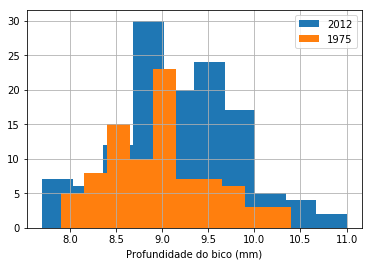

In [4]:
_ = plt.hist(bd_2012, label='2012')
_ = plt.hist(bd_1975, label='1975')
_ = plt.xlabel('Profundidade do bico (mm)')
plt.grid()
plt.legend()
plt.show()

### 1.1.1) ECDFs de profundidades de bico
Plotando as ECDFs para as medições de profundidade de bico de 1975 e 2012 no mesmo gráfico.

As profundidades dos bicos dos respectivos anos foram armazenadas nas arrays NumPy bd_1975 e bd_2012.

In [5]:
# função distribuição de probabilidade acumulada empirica (ECDF)
def ecdf(data):
    """Computando a ECDF para array de uma dimensão."""
    # número de pontos: n
    n = len(data)

    # ordenando os dados
    x = np.sort(data)

    # ECDF
    y = np.arange(1, n+1) / n

    return x, y

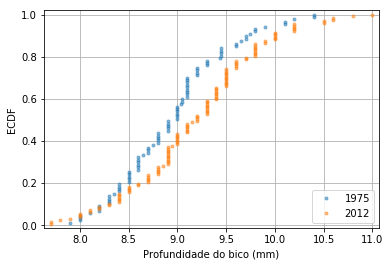

In [6]:
# computando as ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# plotando as ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none', alpha=0.5)
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none', alpha=0.5)
plt.margins(0.02)
_ = plt.xlabel('Profundidade do bico (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')
plt.grid()
plt.show()

## 1.2) Estimação de parâmetros de profundidades de bico
Agora vou estimar a diferença da profundidade média do bico das amostras de _G. scandens_ entre 1975 e 2012, e vou verificar o intervalo de confiança de 95%.

In [7]:
# função para gerar reamostragens de umarray de 1d
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [8]:
# função para gerar reamostragens dos dados 
def draw_bs_reps(data, func, size=1):
    """Bootstrap."""

    # array vazia para popular: bs_replicates
    bs_replicates = np.empty(size)

    # gerando réplicas
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [9]:
# computando a diferença das médias amostrais: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# gerando réplicas de reamostragens das médias
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# computando diferença das médias amostrais: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# computando intevalo de confiança de 95%: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# visualizando os resultados
print('diferença de médias =', mean_diff, 'mm')
print('Intervalo de conf. 95% =', conf_int, 'mm')

diferença de médias = 0.22622047244094645 mm
Intervalo de conf. 95% = [0.05955512 0.39146269] mm


## 1.3) Teste de hipótese: os bicos são mais profundos em 2012?
A ECDF e a determinação do intervalo de confiança deixam bem claro que os bicos de _G. scandens_ em Daphne Major ficaram mais profundos. Mas é possível que esse efeito seja devido apenas ao acaso? Em outras palavras, qual é a probabilidade de obtermos a diferença observada na profundidade média do bico se as médias forem as mesmas?

Aqui é bom ser cuidadoso! A hipótese que estamos testando não é que as profundidades dos bicos venham da mesma distribuição. Para isso, poderíamos usar um teste de permutação. A hipótese é que os meios são iguais. Para executar esse teste de hipótese, precisamos mudar os dois conjuntos de dados para que eles tenham a mesma média, e em seguida, usar a amostragem de autoinicialização para calcular a diferença de médias.

In [10]:
# computando a média do data set combinado: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# shiftando as amostras
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# obtendo as réplicas reamostradas dos dados shiftados
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# computando as réplicas das diferenças das médias: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# computando o p-valor: p
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# visualizando o p-valor
print('p =', p)

p = 0.0031


O p-valor é de 0,003, o que sugere que há uma diferença estatisticamente significativa. Mas lembre-se: é muito importante saber o quão diferentes eles são! Anteriormente obtive uma diferença de 0,2 mm entre as médias. É importante combinar isso com a significância estatística. Mudar 0,2mm em 37 anos é substancial para os padrões evolutivos. Se continuasse mudando nesse ritmo, a profundidade do bico dobraria em apenas 400 anos!

Bom, podemos concluir que a profundidade do bico da espécie  _G. scandens_ mudou nos últimos 37 anos. E segundo os pesquisadores existem poucas hipóteses que levaram à esse fato, uma delas é devido a uma seca que ocorreu entre 1976 e 1977, no qual ocasionou a morte de plantas na ilha que produziam sementes pequenas. 

In [11]:
seeds = pd.read_csv('small_seeds.csv')
seeds

,year,seed_size,mass_seed
0,1976,small,680
1,1976,large,880
2,1977,small,98
3,19977,large,900


E sementes grandes requer bicos profundos para quebrar elas, então pássaros com bicos maiores sobreviveram e se reproduziram.

Se esse for o caso, aí está a razão no qual o comprimento do bico também deve mudar ao longo do tempo, e se o comprimento e a profundidade do bico muda com a mesma taxa, o bico terá o mesmo formato, porém maior. Porém se o comprimento e a profundidade do bico mudam de maneira diferente, o formato do bico também muda.

Na parte 2 desse estudo irei investigar como o comprimento e a profundidade do bico mudam juntas.

# Parte 2

## 2.1) EDA do comprimento dos bicos

Os dados do comprimento do bico serão armazenados como bl_1975 e bl_2012, novamente com unidades de milímetros (mm). Farei gráficos de dispersão da profundidade do bico (eixo y) versus comprimento do bico (eixo x) para as amostras de 1975 e 2012.

In [12]:
bl_1975 = np.array(finch_beaks_1975['Beak length, mm'][finch_beaks_1975.species == 'scandens'])
bl_2012 = np.array(finch_beaks_2012['blength'][finch_beaks_2012.species == 'scandens'])

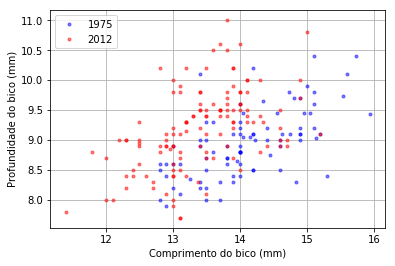

In [13]:
_ = plt.plot(bl_1975, bd_1975, marker='.', linestyle='None', color='blue', alpha=0.5)
_ = plt.plot(bl_2012, bd_2012, marker='.', linestyle='None', color='red', alpha=0.5)
_ = plt.xlabel('Comprimento do bico (mm)')
_ = plt.ylabel('Profundidade do bico (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')
plt.grid()
plt.show()

## 2.2) Regressão linear
Vou executar uma regressão linear para os dados de 1975 e 2012. Em seguida, farei estimativas de autoinicialização dos pares para os parâmetros de regressão. Computarei os intervalos de confiança de 95% na inclinação e interceptação da linha de regressão.

In [14]:
# função para obtenção de pares de reamostragem
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up dos arrays de índices da amostra: inds
    inds = np.arange(len(x))

    # objetos vazios para receber as reamostragens: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # gerando as reamostragens
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [15]:
# computando regressão linear
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# reamostragens para regressão linear
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# computando intervalos de confiança para os betas
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])

intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# visualizando os resultados
print('1975: slope =', slope_1975, 'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975, 'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012, 'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012, 'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.34397875 0.58987974]
1975: intercept = 2.3908752365842267 conf int = [0.65305511 4.0863543 ]
2012: slope = 0.462630358835313 conf int = [0.32437287 0.60101602]
2012: intercept = 2.9772474982360198 conf int = [1.16292269 4.80938697]


### 2.2.1) Exibindo os resultados da regressão linear
Exibirei aqui os resultados de regressão linear no gráfico de dispersão. Para fazer isso, usarei as primeiras 100 amostras das reamostragens (armazenadas nos argumentos bs_slope_reps_1975, bs_intercept_reps_1975, bs_slope_reps_2012 e bs_intercept_reps_2012) e plotarei as linhas com argumentos das palavras-chave alfa = 0.2 e largura de linha = 0.5 para plt.plot().

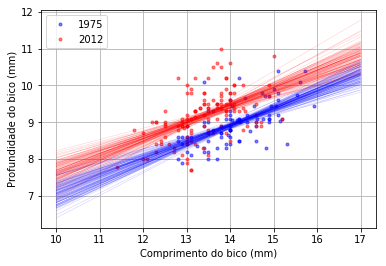

In [16]:
# gráficos de dispersão
_ = plt.plot(bl_1975, bd_1975, marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bl_2012, bd_2012, marker='.',linestyle='none', color='red', alpha=0.5)
_ = plt.xlabel('Comprimento do bico (mm)')
_ = plt.ylabel('Profundidade do bico (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# gerando valores de reamostragem das linhas: x
x = np.array([10, 17])

# plotando as linhas reamostradas
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i], linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i], linewidth=0.5, alpha=0.2, color='red')

plt.grid()
plt.show()

## 2.3) Proporção do comprimento do bico com relação a profundidade
As regressões lineares mostraram informações interessantes sobre a geometria do bico. A inclinação era a mesma em 1975 e 2012, sugerindo que para cada milímetro ganho em comprimento de bico, as aves ganhavam cerca de meio milímetro de profundidade nos dois anos. No entanto, se estivermos interessados na forma do bico, queremos comparar a proporção entre o comprimento e a profundidade do bico. Vamos fazer essa comparação.

In [17]:
# computando a taxa de comprimento/profundidade dos bicos
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# computando as médias
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# obtendo as réplicas das reamostragens das médias
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# computando o intervalo de confiança de 99%
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# visualizando os resultados
print('1975: mean ratio =', mean_ratio_1975, 'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55720104 1.60131503]
2012: mean ratio = 1.4658342276847767 conf int = [1.44451031 1.48783178]


Calculei a relação comprimento médio/profundidade do bico com intervalos de confiança de 99% para 1975 e 2012. Os resultados desse cálculo são mostrados acima. Além desses resultados, o que você diria sobre a proporção entre o comprimento do bico e a profundidade?

A resposta para essa pergunta é que é impossível dizer se esse é um efeito real ou apenas devido ao ruído sem calcular o p-valor.

# Parte 3

E a pergunta continua: quais são as causas do crescimento dos bicos da espécia _G. scandens_ ao longo do tempo?

Eu mencionei a pressão seletiva causada pela seca. Porém os pesquisadores também observaram que alguns pássaros tinham bicos grandes mesmo antes da seca. Uma explicação interessante é que a espécia _G. scandens_ estariam acasalando com outra espécie da ilha, a _G. fortis_.

Esses pássaros híbridos acasalam com os da espécie _G. scandens_ em um processo no qual é chamado hibridização introgressiva, no qual traz características da espécie _G. fortis_ para a _G. scandens_!

Para avaliar a viabilidade dessa explicação, precisamos saber quão fortemente os traços dos pais são transmitidos para os filhos.

## 3.1) EDA da hereditariedade
A array bd_parent_scandens contém a profundidade média do bico (em mm) de dois progenitores da espécie _G. scandens_. A array bd_offspring_scandens contém a profundidade média do bico da prole dos respectivos pais. As arrays bd_parent_fortis e bd_offspring_fortis contêm as mesmas informações sobre medidas de aves de _G. fortis_.

Farei um gráfico de dispersão da profundidade média do bico da prole (eixo y) versus a profundidade média do bico parental (eixo x) para ambas as espécies.

In [18]:
bd_parent_fortis = pd.read_csv('bd_parent_fortis.csv')
bd_parent_fortis = np.array(bd_parent_fortis.bd_parent_fortis)

bd_offspring_fortis = pd.read_csv('bd_offspring_fortis.csv')
bd_offspring_fortis = np.array(bd_offspring_fortis.bd_offspring_fortis)

bd_parent_scandens = pd.read_csv('bd_parent_scandens.csv')
bd_parent_scandens = np.array(bd_parent_scandens.bd_parent_scandens)

bd_offspring_scandens = pd.read_csv('bd_offspring_scandens.csv')
bd_offspring_scandens = np.array(bd_offspring_scandens.bd_offspring_scandens)

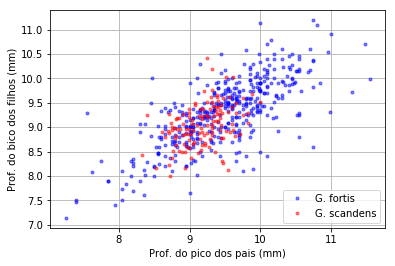

In [19]:
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis, marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens, marker='.', linestyle='none', color='red', alpha=0.5)
_ = plt.xlabel('Prof. do pico dos pais (mm)')
_ = plt.ylabel('Prof. do bico dos filhos (mm)')
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')
plt.grid()
plt.show()

Parece que existe uma correlação mais forte em _G. fortis_ do que em _G. scandens_. Isso sugere que a profundidade do bico é mais fortemente herdada em _G. fortis_. Quantificarei essa correlação a seguir.

## 3.2) Correlação de dados dos filhos e dos pais
Em um esforço para quantificar a correlação entre a profundidade da prole e o bico dos pais, vou calcular o coeficiente de correlação de Pearson, entre pais e filhos. Para obter intervalos de confiança disso farei reamostragems dos pares.

Criarei uma nova função que realiza as reamostragens de pares e calcula uma única estatística nas amostras de pares definidas. A estatística de interesse é calculada chamando func(bs_x, bs_y).

In [20]:
def draw_bs_pairs(x, y, func, size=1):
    """Realiza a reamostragem de pares."""

    # Set up das arrays dos índices das amostras: inds
    inds = np.arange(len(x))

    # objeto vazio para receber as reamostragens: bs_replicates
    bs_replicates = np.empty(size)

    # gerando reamostragens
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

O coeficiente de correlação de Pearson parece ser uma medida útil de quão fortemente a profundidade de bico dos pais é herdada por seus filhos. Calcularei o coeficiente de correlação de Pearson entre as profundidades de bico dos pais e da prole para _G. scandens_. Farei o mesmo para _G. fortis_. Em seguida, usarei as funções criadas para calcular um intervalo de confiança de 95% usando o bootstrap dos pares.

In [21]:
# função para obtenção do coeficiente de Pearson
def pearson_r(x, y):
    """Computa o coeficiente da correlação de Pearson entre duas arrays."""
    # computando a matrix de correlação: corr_mat
    corr_mat = np.corrcoef(x, y)

    return corr_mat[0,1]

In [22]:
# computando os coeficientes de correlação de Pearson
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# obtendo 1.000 reamostragens do coef. de Pearson
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, size=1000)
bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)

# computando o intervalo de confiança de 95%
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# visualizando resultados
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.27216704 0.54525007]
G. fortis: 0.7283412395518486 [0.6666507  0.78009726]


É evidente pelos intervalos de confiança, que a profundidade de bico da prole dos pais de _G. fortis_ está mais fortemente correlacionada com a prole comparada a espécia _G. scandens_.

## 3.3) Medindo a hereditariedade
Lembre-se de que o coeficiente de correlação de Pearson é a razão da covariância para a média geométrica das variâncias dos dois conjuntos de dados. Essa é uma medida da correlação entre pais e filhos, mas pode não ser a melhor estimativa de herdabilidade. Se pararmos e pensarmos, faz mais sentido definir hereditariedade como a razão da covariância entre pai e filho e a variação dos pais sozinhos. A seguir vou estimar a hereditariedade e executar um cálculo de bootstrap de pares para obter o intervalo de confiança de 95%.

Lembrando que na inferência estatística (e a análise de dados em geral) é necessário pensar cuidadosamente sobre as perguntas que deseja responder com seus dados e analisá-las adequadamente. Se você estiver interessado em saber quais são as características de hereditariedade, a quantidade que definimos como hereditariedade é mais adequada que a estatística pronta para uso, no caso o coeficiente de correlação de Pearson.

In [23]:
def heritability(parents, offspring):
    """Computa a herdabilidade."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

In [24]:
# computando a herdabilidade
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

In [25]:
# obtendo 1.000 reamostragens
replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# computando intervalo de confiança de 95%
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# visualizando resultados
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685982 [0.34753684 0.74519318]
G. fortis: 0.7229051911438155 [0.65226548 0.79426494]


Novamente vemos que _G. fortis_ tem herdabilidade mais forte que _G. scandens_. Isto sugere que as características de _G. fortis_ podem ser fortemente incorporadas em _G. scandens_ por hibridização introgressiva.

## 3.4) A profundidade do bico é herdável para a espécie _G. scandens_?
A herdabilidade da profundidade do bico em _G. scandens_ parece baixa. Pode ser que essa herdabilidade observada tenha sido alcançada apenas por acaso e a profundidade do bico não seja realmente hereditária na espécie. Para verificar isso, farei um teste de permutação de pares.

In [26]:
# array de réplicas de reamostragens vazias: perm_replicates
perm_replicates = np.empty(10000)

for i in range(10000):
    # permutação das profundidades dos bicos dos parentes
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted,
                                      bd_offspring_scandens)

# computando o p-valor: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# visualizando o p-valor
print('p-val =', p)

p-val = 0.0


Obtivemos um p-valor igual a zero, o que significa que nenhum dos 10.000 pares de permutações que gerei tinha uma herdabilidade alta o suficiente para corresponder ao que foi observado. Isso sugere fortemente que a profundidade do bico é herdável em _G. scandens_, mas não tanto quanto em _G. fortis_.

# Fim ;*